## Import Libraries and Fetch Data
- `yfinance`: Used to download historical market data.
- `pandas`: Provides data structures to work with data in tabular format.
- `matplotlib.pyplot`: Used for plotting graphs and visualizing data.
- `sklearn.linear_model`: Provides linear regression and ridge regression models.
- `sklearn.metrics`: Used for evaluating the performance of models.
- `sklearn.model_selection`: Provides tools for splitting data into training and test sets.

In [85]:
import yfinance as yf
import pandas as pd
# import mplfinance as mpl
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [86]:
EPOCHS = 50

In [87]:
def compute_rsi(data, window):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

### Fetch Data from `yfinance`
- Downloads historical price data for Bitcoin, Ethereum, Gold, and Oil from Yahoo Finance.
- Specifies the date range from January 1, 2010, to August 2, 2024.
- Prints the first few rows of each dataset to verify the correct data retrieval.

In [88]:
bitcoin = yf.download("BTC-USD", start="2014-01-01", end="2024-08-02")
# etherium = yf.download("ETH-USD", start="2015-01-01", end="2024-08-2")
gold = yf.download("GOLD", start="2014-01-01", end="2024-08-02")
oil = yf.download("IMO", start="2014-01-01", end="2024-08-02")


display("Bitcoin Data:", bitcoin.head())
# display("Ethereum Data:", etherium.head())
display("Gold Data:", gold.head())
display("Oil Data:", oil.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


'Bitcoin Data:'

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


'Gold Data:'

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,17.959999,18.350000,17.910000,18.309999,15.204333,17437300
2014-01-03,18.430000,18.520000,18.080000,18.150000,15.071476,13974300
2014-01-06,18.450001,18.559999,18.170000,18.350000,15.237549,11572400
2014-01-07,18.190001,18.299999,17.950001,18.270000,15.171117,10197600
2014-01-08,18.110001,18.110001,17.780001,17.959999,14.913700,13334700


'Oil Data:'

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,44.349998,44.490002,43.549999,43.599998,35.126644,263200
2014-01-03,43.619999,43.919998,43.459999,43.639999,35.158867,235400
2014-01-06,43.639999,43.639999,42.799999,43.139999,34.756039,260000
2014-01-07,43.150002,43.619999,43.150002,43.290001,34.876884,147100
2014-01-08,43.279999,43.279999,42.400002,42.540001,34.272633,229200


## Prepare the DataFrame and Align Datasets
- Creates a new DataFrame main_data by copying Bitcoin data.
- Adds new columns to main_data:

    - **Benefit**: The difference between the closing and opening prices.
    - **Tomorrow**: The closing price shifted one day into the future.
    - **MA-5**, **MA-15**, **MA-30**, **MA-50**: Moving averages over 5, 15, 30, and 50 days, respectively.
    - **EMA-12**, **EMA-26**: Exponential moving averages over 12 and 26 days, respectively.
    - **MACD**
    - **Signal Line**
    - **RSI**
- Aligns additional datasets (Ethereum, Gold, and Oil) with the main DataFrame by adding their closing prices.
- Drops rows with missing values to ensure all data points match up correctly.

In [89]:
main_data = bitcoin
main_data['Benefit'] = bitcoin.Close - bitcoin.Open
main_data['Tomorrow'] = main_data['Close'].shift(-1)
main_data['MA-5'] = main_data['Close'].rolling(5).mean()
main_data['MA-15'] = main_data['Close'].rolling(15).mean()
main_data['MA-30'] = main_data['Close'].rolling(30).mean()
main_data['MA-50'] = main_data['Close'].rolling(50).mean()
main_data['EMA-12'] = main_data['Close'].ewm(span=12, adjust=False).mean()
main_data['EMA-26'] = main_data['Close'].ewm(span=26, adjust=False).mean()
main_data['MACD'] = main_data['EMA-12'] - main_data['EMA-26']
main_data['Signal_Line'] = main_data['MACD'].ewm(span=9, adjust=False).mean()
main_data['RSI'] = compute_rsi(main_data['Close'], 14)
# main_data['Etherium'] = etherium.Close
main_data['Gold'] = gold.Close
main_data['OIL'] = oil.Close

main_data.dropna(inplace=True)

display(main_data)

,Open,High,Low,Close,Adj Close,Volume,Benefit,Tomorrow,MA-5,MA-15,MA-30,MA-50,EMA-12,EMA-26,MACD,Signal_Line,RSI,Gold,OIL
Date,,,,,,,,,,,,,,,,,,,
2014-11-05,330.683014,343.368988,330.683014,339.485992,339.485992,19817200,8.802979,349.290009,329.834595,345.392800,361.337801,372.766840,341.428681,355.152231,-13.723550,-12.481904,30.962180,10.970000,46.549999
2014-11-06,339.458008,352.966003,338.424011,349.290009,349.290009,18797000,9.832001,342.415009,334.542798,343.134934,361.774568,370.605960,342.638116,354.717992,-12.079876,-12.401498,45.425576,11.340000,46.889999
2014-11-07,349.817993,352.731995,341.776001,342.415009,342.415009,16834200,-7.402985,345.488007,337.847400,342.068136,361.423735,368.965460,342.603792,353.806660,-11.202868,-12.161772,42.525624,12.160000,47.630001
2014-11-10,362.265015,374.816010,357.561005,366.924011,366.924011,30450100,4.658997,367.695007,353.476208,343.091870,360.983368,366.428561,349.352556,354.898678,-5.546122,-9.878974,56.285462,11.350000,47.500000
2014-11-11,365.856995,371.309998,363.734985,367.695007,367.695007,15838900,1.838013,423.561005,357.157208,344.072270,360.621568,365.739421,352.174472,355.846555,-3.672083,-8.637596,54.709184,11.640000,47.389999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,65375.875000,66112.421875,63473.472656,65777.226562,65777.226562,38315761670,401.351562,67912.062500,66563.360937,64000.992969,61720.708203,63527.788516,64948.465241,63626.534952,1321.930288,774.716104,75.956346,17.719999,70.599998
2024-07-26,65771.812500,68207.601562,65743.765625,67912.062500,67912.062500,30488630457,2140.250000,67813.335938,66514.868750,64705.469531,61957.401042,63470.886484,65404.403281,63943.981437,1460.421843,911.857251,78.088124,17.790001,71.029999
2024-07-29,68259.054688,69987.539062,66532.593750,66819.914062,66819.914062,40780682628,-1439.140625,66201.015625,67315.681250,66370.129948,62626.627734,63362.741797,66258.715081,64698.482715,1560.232365,1237.067323,57.598409,17.969999,69.059998


In [90]:
main_data.corr()

,Open,High,Low,Close,Adj Close,Volume,Benefit,Tomorrow,MA-5,MA-15,MA-30,MA-50,EMA-12,EMA-26,MACD,Signal_Line,RSI,Gold,OIL
Open,1.000000,0.999467,0.999180,0.998728,0.998728,0.666428,-0.026433,0.997859,0.999364,0.996341,0.991131,0.982903,0.998149,0.994573,0.239244,0.253846,-0.024495,0.361228,0.506588
High,0.999467,1.000000,0.999096,0.999496,0.999496,0.671715,-0.000629,0.998585,0.999177,0.996051,0.990690,0.982316,0.997921,0.994196,0.241932,0.255749,-0.019438,0.362208,0.502429
Low,0.999180,0.999096,1.000000,0.999374,0.999374,0.657173,0.002646,0.998404,0.998773,0.995424,0.990295,0.982122,0.997428,0.993772,0.240589,0.252577,-0.018183,0.359972,0.511269
Close,0.998728,0.999496,0.999374,1.000000,1.000000,0.665815,0.024014,0.999006,0.998669,0.995200,0.989809,0.981396,0.997259,0.993384,0.244544,0.256199,-0.014015,0.361470,0.505597
Adj Close,0.998728,0.999496,0.999374,1.000000,1.000000,0.665815,0.024014,0.999006,0.998669,0.995200,0.989809,0.981396,0.997259,0.993384,0.244544,0.256199,-0.014015,0.361470,0.505597
Volume,0.666428,0.671715,0.657173,0.665815,0.665815,1.000000,-0.012957,0.666410,0.667635,0.665425,0.656006,0.645906,0.666135,0.660261,0.223300,0.248872,-0.000132,0.516293,0.048862
Benefit,-0.026433,-0.000629,0.002646,0.024014,0.024014,-0.012957,1.000000,0.021521,-0.014973,-0.023828,-0.027406,-0.031070,-0.018854,-0.024775,0.104770,0.046331,0.207759,0.004363,-0.020254
Tomorrow,0.997859,0.998585,0.998404,0.999006,0.999006,0.666410,0.021521,1.000000,0.997721,0.994155,0.988730,0.980232,0.996257,0.992318,0.245551,0.257077,-0.012430,0.361695,0.503546
MA-5,0.999364,0.999177,0.998773,0.998669,0.998669,0.667635,-0.014973,0.997721,1.000000,0.997728,0.992629,0.984561,0.999168,0.995932,0.233219,0.251779,-0.031667,0.361616,0.506810
MA-15,0.996341,0.996051,0.995424,0.995200,0.995200,0.665425,-0.023828,0.994155,0.997728,1.000000,0.997312,0.990627,0.999586,0.998984,0.185231,0.217862,-0.070473,0.361934,0.509547


## Prepare Data for Modeling

- Defines the feature matrix X by selecting relevant columns from main_data according to the correlation between them.
- Defines the target variable y as the Tomorrow column.
- Splits the data into training and test sets, using 80% for training and 20% for testing, without shuffling to maintain the time series order.

In [91]:
X = main_data[['Close', 'Open', 'High', 'Low', 'MA-5', 'MA-15', 'MA-30', 'MA-50', 'EMA-12', 'EMA-26']]
y = main_data['Tomorrow']

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.2 , shuffle = False)

display(X_train)

,Close,Open,High,Low,MA-5,MA-15,MA-30,MA-50,EMA-12,EMA-26
Date,,,,,,,,,,
2014-11-05,339.485992,330.683014,343.368988,330.683014,329.834595,345.392800,361.337801,372.766840,341.428681,355.152231
2014-11-06,349.290009,339.458008,352.966003,338.424011,334.542798,343.134934,361.774568,370.605960,342.638116,354.717992
2014-11-07,342.415009,349.817993,352.731995,341.776001,337.847400,342.068136,361.423735,368.965460,342.603792,353.806660
2014-11-10,366.924011,362.265015,374.816010,357.561005,353.476208,343.091870,360.983368,366.428561,349.352556,354.898678
2014-11-11,367.695007,365.856995,371.309998,363.734985,357.157208,344.072270,360.621568,365.739421,352.174472,355.846555
...,...,...,...,...,...,...,...,...,...,...
2022-08-11,23957.529297,23948.345703,24822.628906,23900.996094,23610.973438,23381.124349,22663.265234,21790.882812,23348.040971,22929.176613
2022-08-12,24402.818359,23957.203125,24412.566406,23657.265625,23856.358984,23418.386458,22802.956706,21857.221641,23510.314415,23038.335261
2022-08-15,24136.972656,24318.316406,25135.589844,23839.775391,24248.144531,23557.229036,23145.750391,22039.603359,23812.689716,23295.578972


## Initialize Models and Results Dictionary
- Defines a dictionary of models to be evaluated, including Linear Regression, Ridge Regression, and Lasso.
- Initializes a dictionary to store the results for each model, including model names, training RMSE, test RMSE, all RSME.

In [84]:
models = [LinearRegression(n_jobs=2), Lasso(), Ridge()]

results = {"Model" : [],
              "All RMSE" : [],
              "Train RMSE" : [],
              "Test RMSE" : []}

## Train and Evaluate Each Model

- Iterates over each model in the models dictionary.
- Records the start time, trains the model on the training data.
- Predicts the training and test data using the trained model.
- Calculates the RMSE for both the training and test predictions.
- Appends the model name, training RMSE, test RMSE, and all RMSE to the results dictionary.

In [93]:
for model in models:  
    model.fit(X_train, y_train)

    all_pred = model.predict(X)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate
    all_rmse = root_mean_squared_error(y, all_pred)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)


    print("Model :", model.__str__())
    print("All RMSE :", all_rmse)
    print("Train RMSE :", train_rmse)
    print("Test RMSE :", test_rmse)
    print("---------------------------------")

    
    results["Model"].append(model.__str__())
    results["All RMSE"].append(all_rmse)
    results["Train RMSE"].append(train_rmse)
    results["Test RMSE"].append(test_rmse)

Model : LinearRegression(n_jobs=2)
All RMSE : 854.0540051759747
Train RMSE : 786.0262195937238
Test RMSE : 1084.1884758930316
---------------------------------
Model : Lasso()
All RMSE : 854.4403671496653
Train RMSE : 786.5293633600972
Test RMSE : 1084.2511328069384
---------------------------------
Model : Ridge()
All RMSE : 854.0540051586019
Train RMSE : 786.0262195937239
Test RMSE : 1084.1884758246335
---------------------------------


c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.058e+08, tolerance: 5.395e+07
  model = cd_fast.enet_coordinate_descent(


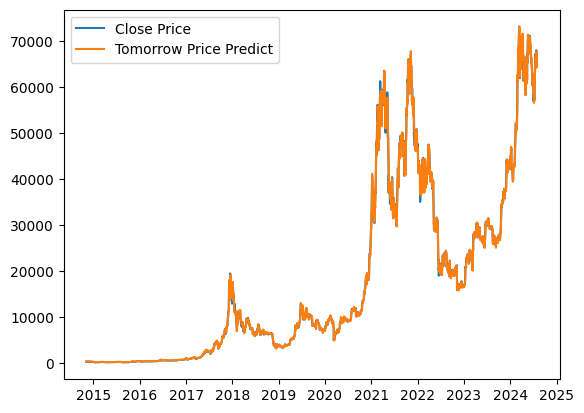

In [74]:
plt.plot(X.index, y, label="Close Price")
plt.plot(X.index, all_pred, label="Tomorrow Price Predict")
plt.legend()

plt.show()


### Plotting the Results
- Creates a figure with three subplots, sized 18x6 inches.
- First Subplot: Plots the ***training RMSE*** for each model as a bar chart.
- Second Subplot: Plots the ***test RMSE*** for each model as a bar chart.
- Third Subplot: Plots the ***all RMSE*** for each model as a bar chart.
- Sets titles, labels, and colors for each subplot.
- Adjusts the layout to prevent overlapping and displays the plots.

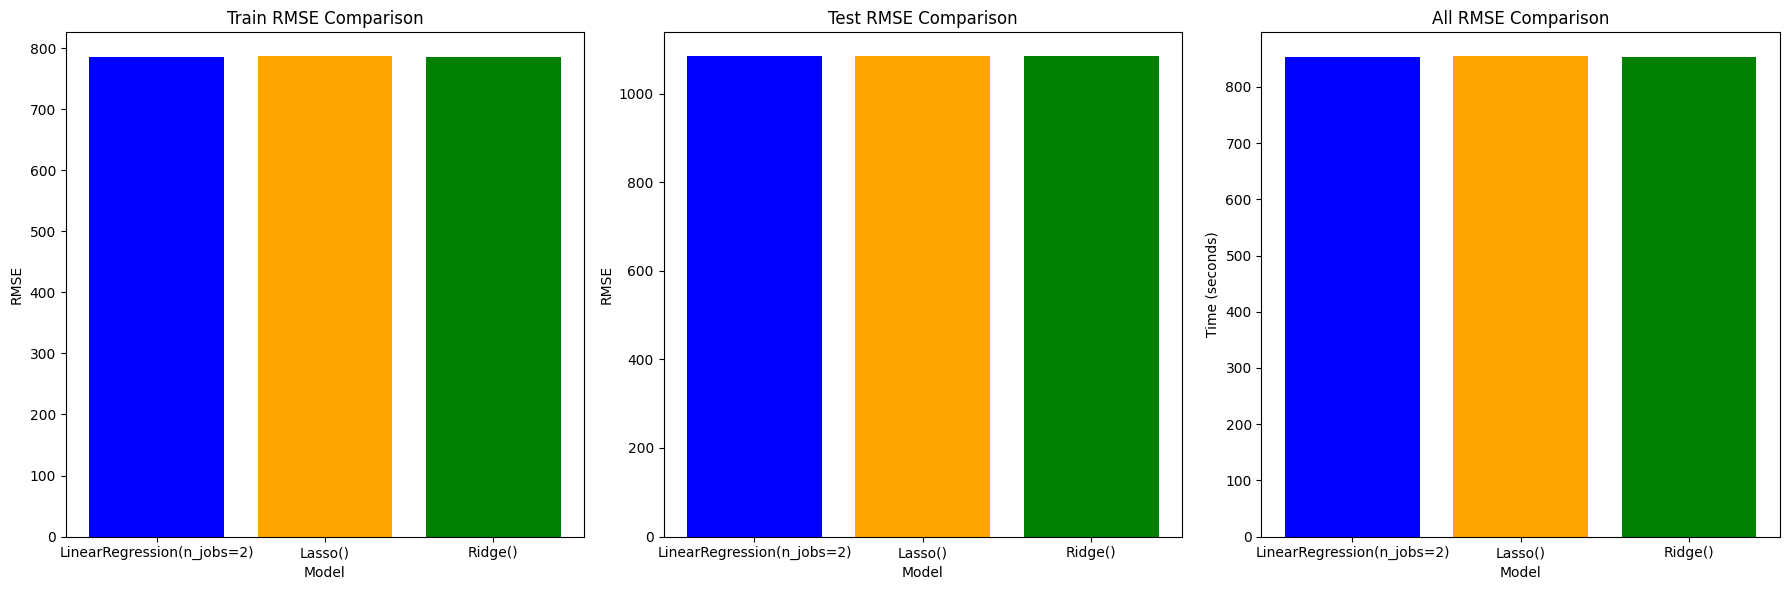

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Train RMSE
axes[0].bar(results['Model'], results['Train RMSE'], color=['blue', 'orange', 'green'])
axes[0].set_title('Train RMSE Comparison')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')

# Plot Test RMSE
axes[1].bar(results['Model'], results['Test RMSE'], color=['blue', 'orange', 'green'])
axes[1].set_title('Test RMSE Comparison')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Model')

# Plot Training Time
axes[2].bar(results['Model'], results['All RMSE'], color=['blue', 'orange', 'green'])
axes[2].set_title('All RMSE Comparison')
axes[2].set_ylabel('RMSE')
axes[2].set_xlabel('Model')

plt.tight_layout()
plt.show()